In [52]:
%matplotlib inline
import itertools
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import pickle
from scipy.optimize import curve_fit

In [53]:
cwd = os.getcwd()
path1 = cwd + '/hole/results_REG.txt'
path2 = cwd + '/hole/results_UNI.txt'
path3 = cwd + '/hole/results_SOB.txt'
#data = np.concatenate((np.loadtxt(path1), np.loadtxt(path2)))
dataREG = np.loadtxt(path1)
dataUNI = np.loadtxt(path2)
dataSOB = np.loadtxt(path3)
data = np.concatenate((dataREG, dataUNI, dataSOB))

In [54]:
# create a boolean mask based on your conditions
mask = (dataSOB[:, 6] >= 0) #& (data[:, 2] == 1) & (data[:, 1] == 6)

# use the boolean mask to select the values
avg_distSOB = dataSOB[mask, 3]
avg_outSOB = dataSOB[mask, 4]
test_errSOB = dataSOB[mask, 6]
train_errSOB = dataSOB[mask, 5]

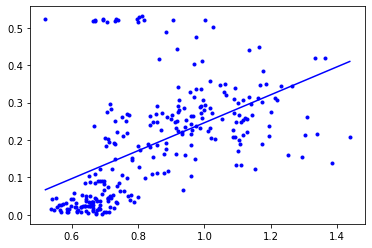

In [55]:
# calculate polynomial
z_dist = np.polyfit(avg_distSOB, test_errSOB, 1)
f_dist = np.poly1d(z_dist)

# calculate new x's and y's
x_dist = np.linspace(min(avg_distSOB), max(avg_distSOB), 100)
y_dist = f_dist(x_dist)

plt.plot(x_dist, y_dist, color='blue')
plt.plot(avg_distSOB, test_errSOB, '.', color='blue')
plt.show()

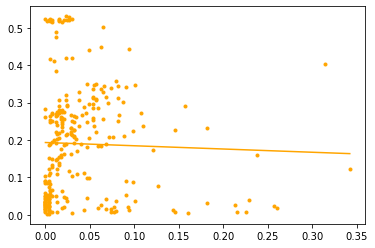

In [56]:
z_out = np.polyfit(avg_outSOB, test_errSOB, 1)
f_out = np.poly1d(z_out)

x_out = np.linspace(min(avg_outSOB), max(avg_outSOB), 100)
y_out = f_out(x_out)

plt.plot(x_out, y_out, color='orange')
plt.plot(avg_outSOB, test_errSOB, '.', color='orange')

In [57]:
# Define a function to deserialize the data
def deserialize(name, folder_name):
    with open(os.path.join(folder_name, name + ".pkl"), 'rb') as f:
        data = pickle.load(f, encoding='latin1', fix_imports=True)
    return data

In [58]:
################# CHOOSE SAMPLING METHOD #################
sampling_method = 'SOB' # Either REG, UNI, or SOB for regular (grid), random (uniform), and Sobol

# Deserialize the data using pickle
folder_name = "serialized_hole/serialized_data_" + sampling_method + "_10_3_1"
list_names = ["list_dist_nv", "mean_dist", "mean_nv", "num_out", "output_test", "stdv_nv"]
list_data = []
for name in list_names:
    list_data.append(deserialize(name, folder_name))
    
list_dist_nv = list_data[0]
mean_dist = list_data[1]
mean_nv = list_data[2]
num_out = list_data[3]
output_test = list_data[4].detach().numpy()
stdv_nv = list_data[5]

In [59]:
train_size = 1024
test_size = 529
train_path = 'samples/train_data_f1_hole_' + str(train_size)
test_path = 'samples/test_data_f1_plain_' + str(test_size) + '/'

# Training and Testing samples
x_train, y_train = deserialize(sampling_method + "_x_train", train_path), deserialize(sampling_method + "_y_train", train_path)
x_test, y_test = deserialize("x_test", test_path), deserialize("y_test", test_path)

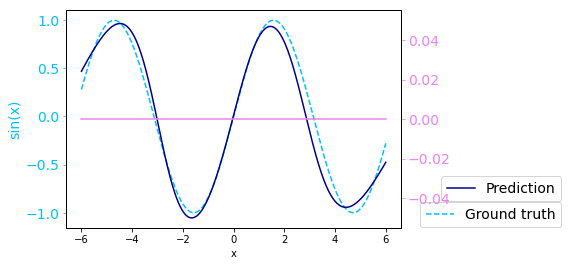

In [60]:
#Plot showing the number of nodes outside of range for a network
#and its prediction, compared to the ground truth

fig, ax1 = plt.subplots()

plt.rcParams["figure.figsize"] = (6,5)

p1, = ax1.plot(x_test, y_test, '--', color='deepskyblue')
ax1.set_ylabel('sin(x)')
ax1.set_xlabel('x')
ax1.legend(['Ground truth'], bbox_to_anchor=(0., 0.15))
ax1.yaxis.label.set_color(p1.get_color())
ax1.yaxis.label.set_fontsize(14)
ax1.tick_params(axis='y', colors=p1.get_color(), labelsize=14)

ax2 = ax1.twiny()
p2, = ax2.plot(x_test, output_test, color='darkblue')
ax2.legend(['Prediction'], bbox_to_anchor=(1.5, 0.27))
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)

ax3 = ax1.twinx()
p3, = ax3.plot(x_test, num_out, color='violet')
ax3.yaxis.label.set_color(p3.get_color())
ax3.yaxis.label.set_fontsize(14)
ax3.tick_params(axis='y', colors=p3.get_color(), labelsize=14)

plt.savefig("images/f1_10_3_out_holeSOB.png", dpi=100)

In [61]:
#definition of a cost function
def mse(pred, truth):
    res = []
    for p, t in zip(pred, truth):
        res.append((p[0]-t[0])**2)
    return np.array(res)

In [62]:
################# CHOOSE SAMPLING METHOD #################
sampling_method = 'SOB' # Either REG, UNI, or SOB for regular (grid), random (uniform), and Sobol

archs = [(6, 1), (7, 1), (12, 1), (17, 1), (22, 1), (27, 1), (32, 1),
    (6, 2), (8, 2), (10, 2), (12, 2), (14, 2), (16, 2),
    (6, 3), (8, 3), (10, 3)]
path = "serialized_hole/serialized_data_" + sampling_method

full_err = np.array([])
full_out = np.array([])
full_dist = np.array([])
full_xtest = np.array([])
X = x_test.detach().numpy().reshape(1, len(x_test))[0]
for width, depth in archs:
    for test_num in range(1, 18):
        # Deserialize the data using pickle
        folder_name = path + f"_{width}_{depth}_{test_num}"
        list_names = ["mean_dist", "num_out", "output_test"]
        list_data = []
        for name in list_names:
            list_data.append(deserialize(name, folder_name))

        mean_dist = list_data[0]
        num_out = list_data[1]
        output_test = list_data[2].detach().numpy()
        gen_err = mse(output_test, y_test)
        
        full_err = np.concatenate((full_err, gen_err))
        full_out = np.concatenate((full_out, num_out))
        full_dist = np.concatenate((full_dist, mean_dist))
        full_xtest = np.concatenate((full_xtest, X))

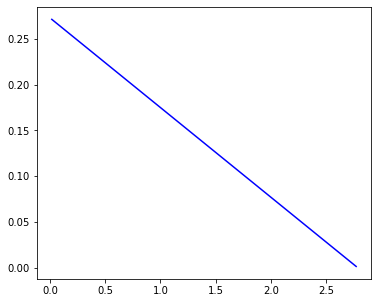

In [63]:
# calculate polynomial
z_dist = np.polyfit(full_dist, full_err, 1)
f_dist = np.poly1d(z_dist)

# calculate new x's and y's
x_dist = np.linspace(min(full_dist), max(full_dist), 20)
y_dist = f_dist(x_dist)

plt.plot(x_dist, y_dist, color='blue')
#plt.plot(full_dist, full_err, '.', color='blue')
plt.show()

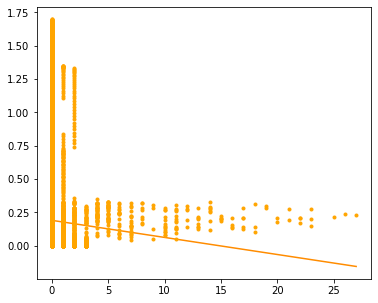

In [64]:
# calculate polynomial
z_dist = np.polyfit(full_out, full_err, 1)
f_dist = np.poly1d(z_dist)

# calculate new x's and y's
x_dist = np.linspace(min(full_out), max(full_out), 20)
y_dist = f_dist(x_dist)

plt.plot(x_dist, y_dist, color='darkorange')
plt.plot(full_out, full_err, '.', color='orange')
plt.show()

In [65]:
# Collect only node values outside of training range
stack = np.column_stack((full_out, full_dist, full_xtest, full_err))

# create a boolean mask based on your conditions
mask = np.logical_or((-6 <= stack[:, 2]) & (stack[:, 2] <= -4), (-1 <= stack[:, 2]) & (stack[:, 2] <= 1), (4 <= stack[:, 2]) & (stack[:, 2] <= 6))

# use the mask to filter the stack array
filtered_stack = stack[mask]

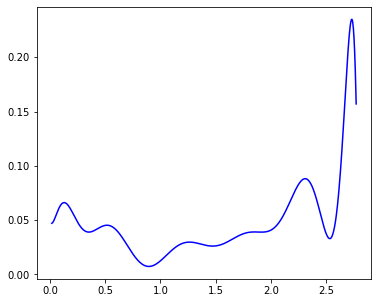

In [66]:
# calculate polynomial
z_dist = np.polyfit(filtered_stack[:, 1], filtered_stack[:, 3], 13)
f_dist = np.poly1d(z_dist)

# calculate new x's and y's
x_dist = np.linspace(min(filtered_stack[:, 1]), max(filtered_stack[:, 1]), 1000)
y_dist = f_dist(x_dist)

plt.plot(x_dist, y_dist, color='blue')
#plt.plot(filtered_stack[:, 1], filtered_stack[:, 3], '.', color='blue')
plt.show()

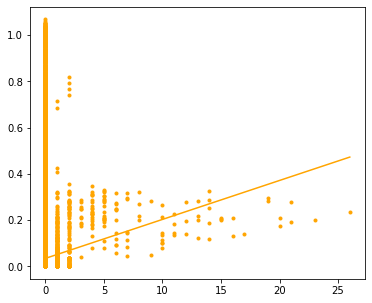

In [67]:
# calculate polynomial
z_dist = np.polyfit(filtered_stack[:, 0], filtered_stack[:, 3], 1)
f_dist = np.poly1d(z_dist)

# calculate new x's and y's
x_dist = np.linspace(min(filtered_stack[:, 0]), max(filtered_stack[:, 0]), 100)
y_dist = f_dist(x_dist)

plt.plot(x_dist, y_dist, color='orange')
plt.plot(filtered_stack[:, 0], filtered_stack[:, 3], '.', color='orange')
plt.show()

In [68]:
avg_out = sum(list(filtered_stack[:, 0])) / len(list(filtered_stack[:, 0]))
avg_dist = sum(list(filtered_stack[:, 1])) / len(list(filtered_stack[:, 1]))
avg_err = sum(list(filtered_stack[:, 3])) / len(list(filtered_stack[:, 3]))
print(avg_out, avg_dist, avg_err)

0.03339805023132849 0.8119594346425398 0.03551098096410385
